<a href="https://colab.research.google.com/github/arizonaCameraLab/computationalImaging/blob/master/Chapter2ForwardModels/bases.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Computational Imaging
### David J. Brady
### University of Arizona

## Bases and dictionaries


This notebook supports ideas developed in section Chapter 2.5 of *Computational Optical Imaging*, focusing specifically on basis functions and wavelet representations.

#### initialization code

In [1]:
pip install PyWavelets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 17.6 MB/s eta 0:00:00


In [2]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
from IPython.display import display, clear_output
import ipywidgets as widgets
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from skimage import io
import scipy.integrate as integrate
#from google.colab import files
%matplotlib inline
import warnings
import scipy.integrate as integrate
import pywt



warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = [15, 7]
plt.rcParams.update({'font.size': 22})

## Sampling projections


Raw measurement data is often defined by the pixel sampling function, which may be for example be a rectangular function. Here we give examples of projections onto the rect, triangle and Gaussian sampling functions.

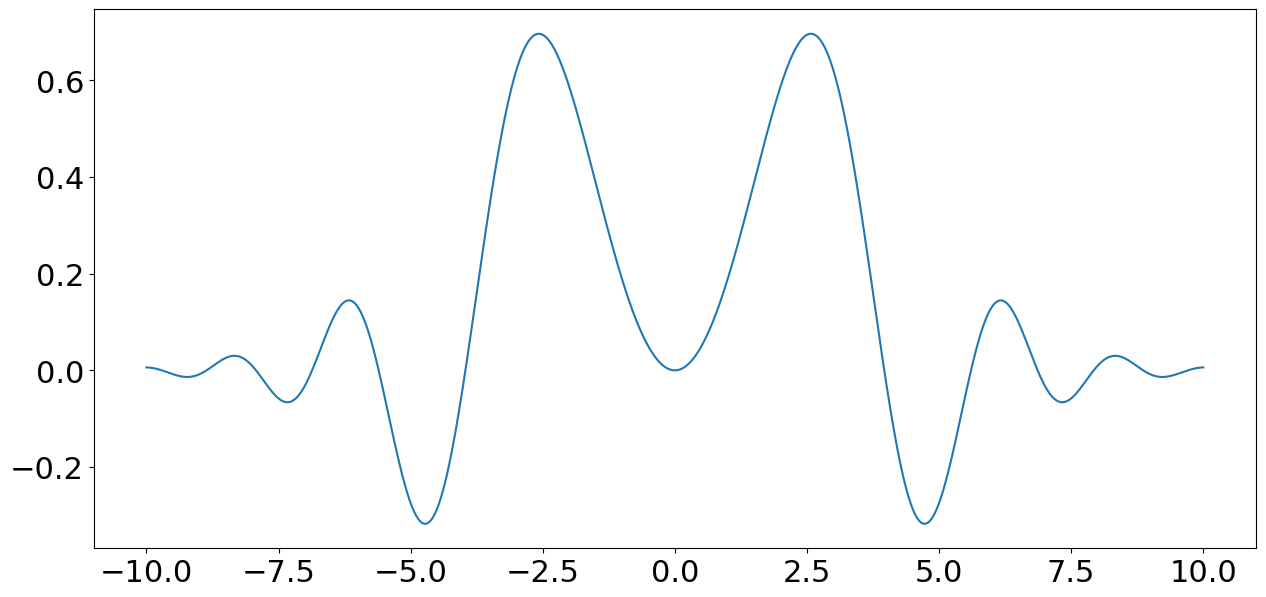

In [82]:
def y(x):
  y = np.sin(.2*x**2)*np.exp(-x**2/20)
  return y
x = np.linspace(-10,10,1000)
plt.plot(x,y(x))
plt.show()


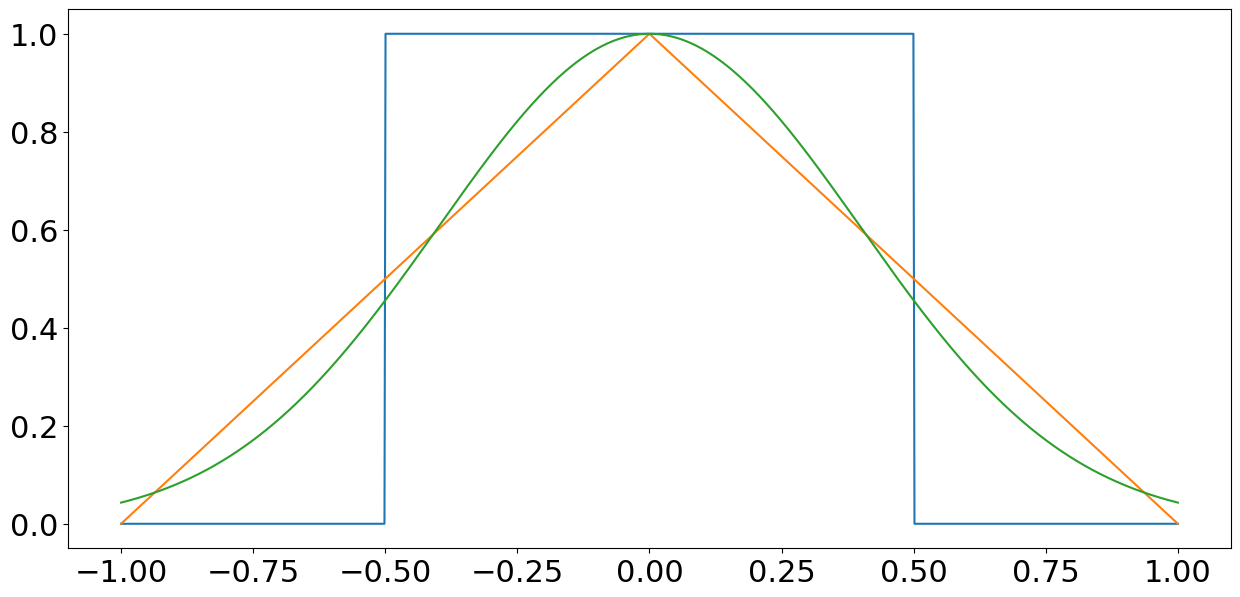

<Figure size 1500x700 with 0 Axes>

In [93]:
plt.figure(figsize=(15,7))
def rect(x):
  rect=np.heaviside(x+.5,0)*np.heaviside(-x+.5,0)
  return rect
def triange(x):
  triangle=(1-abs(x))*rect(x/2.)
  return triangle
def gauss(x):
  gauss=np.exp(-np.pi*x**2)
  return gauss
x = np.linspace(-1,1,1000)
plt.plot(x,rect(x))
plt.plot(x,triange(x))
plt.plot(x,gauss(x))
plt.show()
plt.savefig('samplingFunctions.png')


In [85]:

RSCoeff=np.zeros(21)
for pop in np.arange(-10,11):
  def rectSam(x):
    rs=y(x)*rect(x-pop)
    return rs
  RSCoeff[10+pop]=integrate.quad(rectSam,-10,10)[0]
TSCoeff=np.zeros(21)
for pop in np.arange(-10,11):
  def triSam(x):
    ts=y(x)*triange(x-pop)
    return ts
  TSCoeff[10+pop]=integrate.quad(triSam,-10,10)[0]
GSCoeff=np.zeros(21)
for pop in np.arange(-10,11):
  def gaussSam(x):
    gs=y(x)*gauss(x-pop)
    return gs
  GSCoeff[10+pop]=integrate.quad(gaussSam,-10,10)[0]

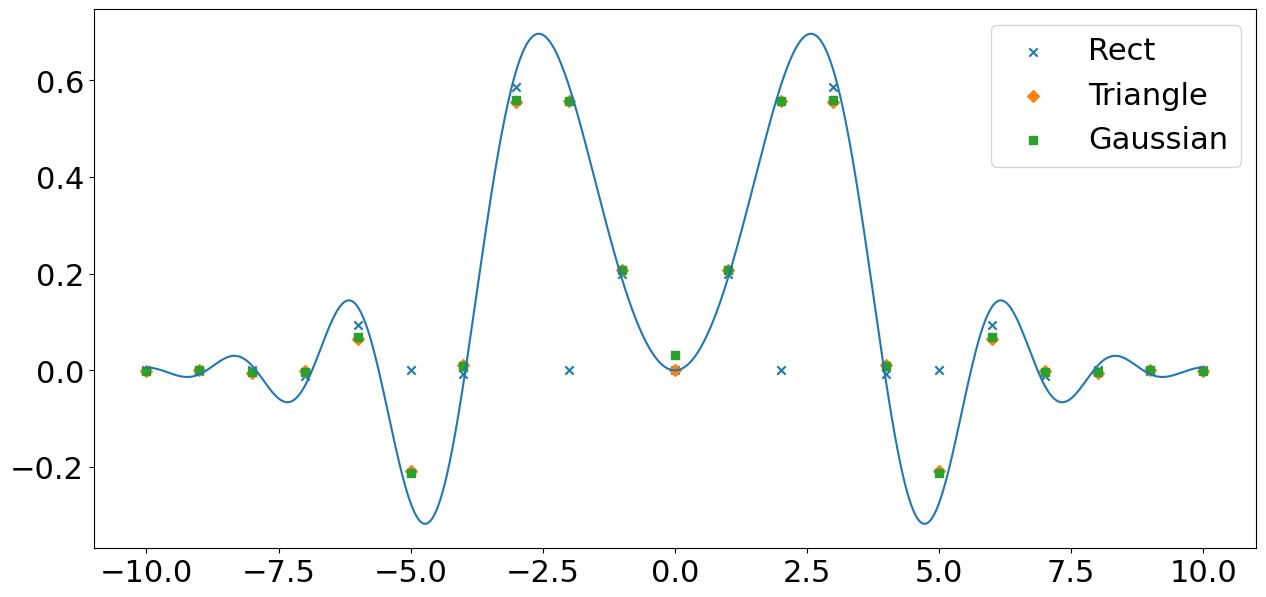

<Figure size 1500x700 with 0 Axes>

In [92]:
plt.figure(figsize=(15,7))
xn=np.linspace(-10,10,21)
plt.scatter(xn,RSCoeff, marker='x')
plt.scatter(xn,TSCoeff, marker='D')
plt.scatter(xn,GSCoeff, marker='s')
x = np.linspace(-10,10,1000)
plt.plot(x,y(x))
plt.legend(['Rect','Triangle','Gaussian'])
plt.show()
plt.savefig('sampling.png')
#files.download('sampling.png')


## The Haar Wavelet

We consider the Haar scaling function
$$
 \phi_{j,n}(x)={1\over \sqrt{2^j}}\beta^0 \left ({{x\over 2^j}-n}\right )
 $$
 and the Haar wavelet
 $$
 \psi_{j,n} (x)=\phi_{j-1,n}(x)-\phi_{j-1,n+1}(x)
 $$


In [ ]:
def betab(x):
  b=(1.-np.sign(np.abs(x-.5)-.5))/2.
  return b
beta=np.vectorize(betab)
def phi(j,n,x):
  phib=beta(x/(2.**j)-n)/np.sqrt(2**j)
  return phib
def psi(j,n,x):
  psib=phi(j-1,n,x)-phi(j-1,n+1,x)
  return psib



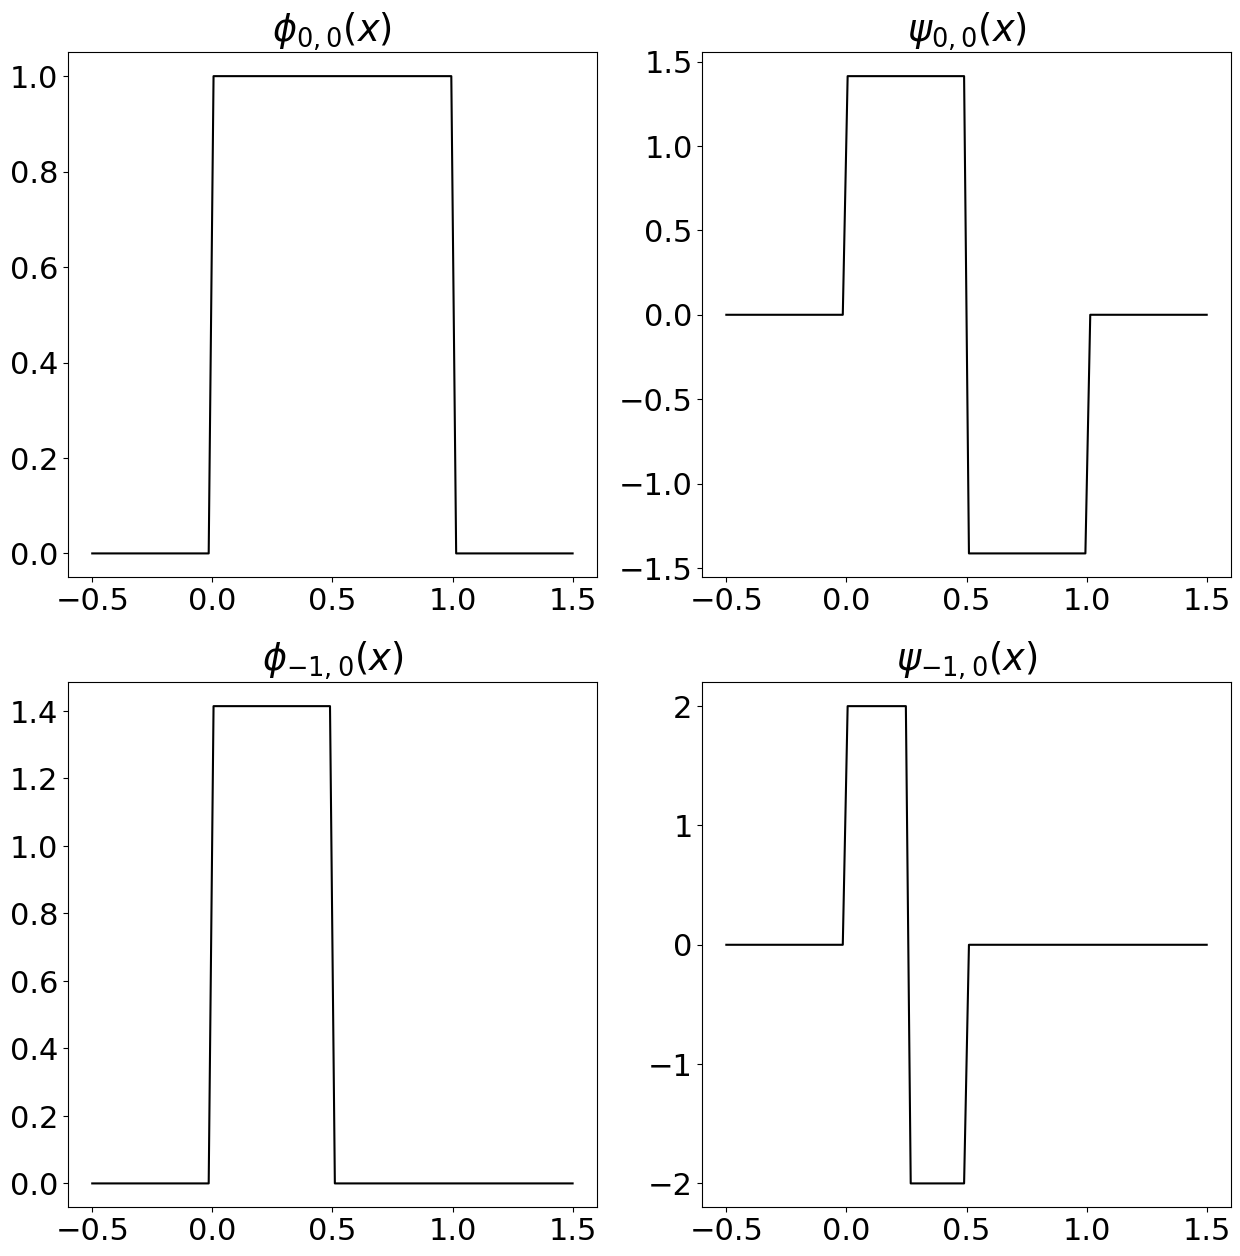

In [ ]:
plt.figure(figsize=(15,15))
xp=np.linspace(-.5,1.5,100)
plt.subplot(2,2,1)
plt.plot(xp,phi(0,0,xp),'k')
plt.title("$\phi_{0,0}(x)$")
plt.subplot(2,2,2)
plt.plot(xp,psi(0,0,xp),'k')
plt.title("$\psi_{0,0}(x)$")
plt.subplot(2,2,3)
plt.plot(xp,phi(-1,0,xp),'k')
plt.title("$\phi_{-1,0}(x)$")
plt.subplot(2,2,4)
plt.plot(xp,psi(-1,0,xp),'k')
plt.title("$\psi_{-1,0}(x)$")
plt.savefig('haarBasis.png')
#files.download('haarBasis.png')

Text(0.5, 1.0, '$\\phi_{-3,0}(x)$')

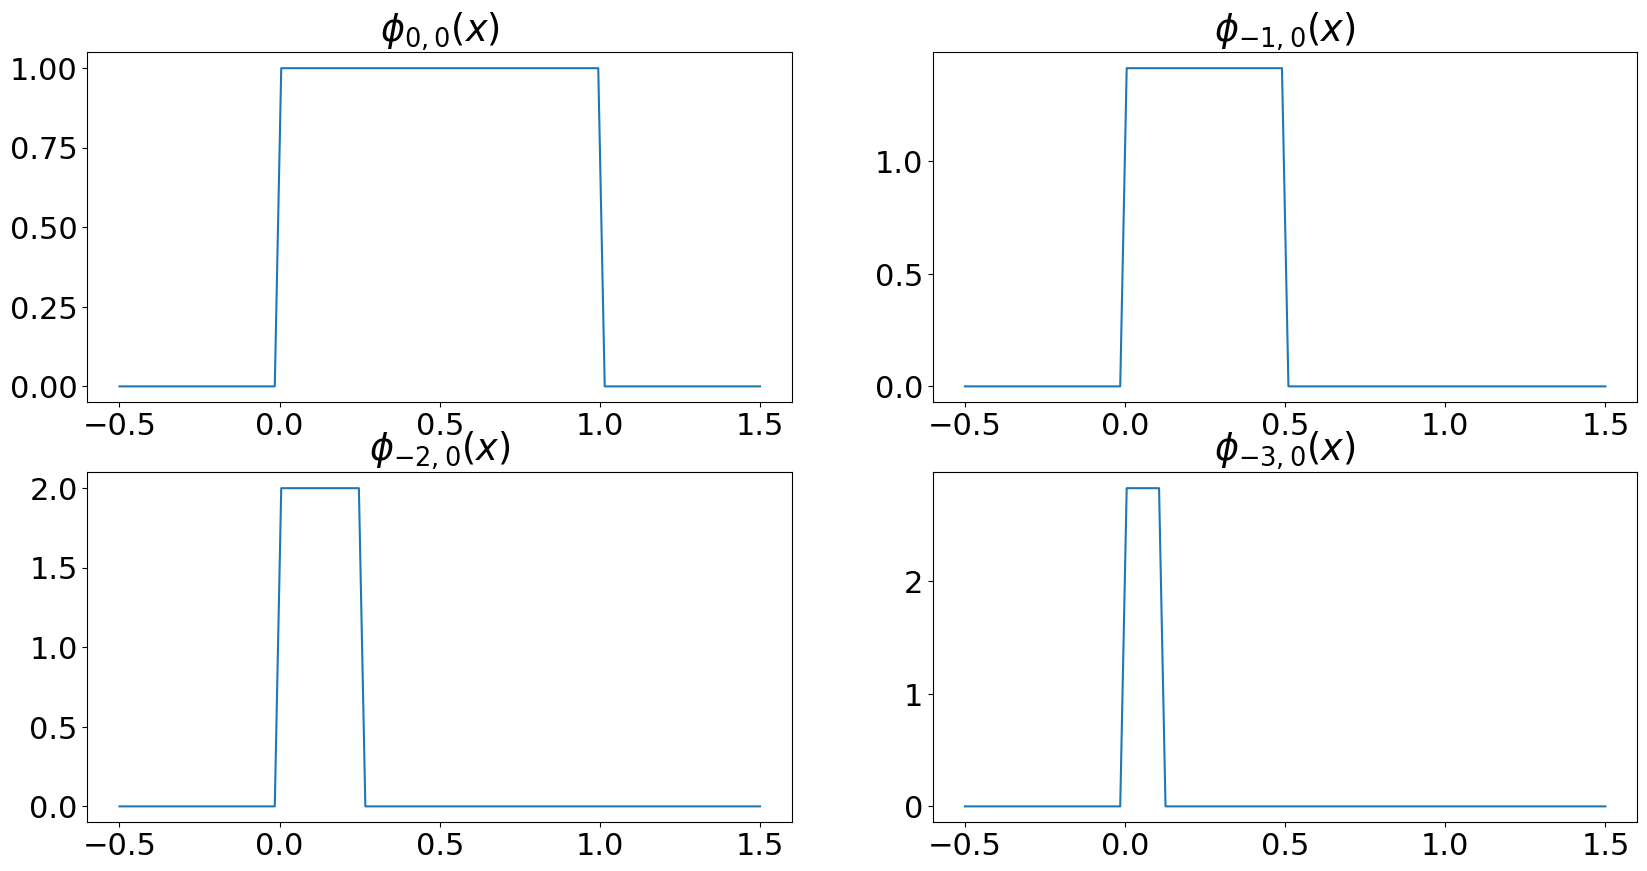

In [ ]:
xp=np.linspace(-.5,1.5,100)
plt.subplot(2,2,1)
plt.plot(xp,phi(0,0,xp))
plt.title("$\phi_{0,0}(x)$")
plt.subplot(2,2,2)
plt.plot(xp,phi(-1,0,xp))
plt.title("$\phi_{-1,0}(x)$")
plt.subplot(2,2,3)
plt.plot(xp,phi(-2,0,xp))
plt.title("$\phi_{-2,0}(x)$")
plt.subplot(2,2,4)
plt.plot(xp,phi(-3,0,xp))
plt.title("$\phi_{-3,0}(x)$")
#plt.savefig('haarBasis.png')
#files.download('haarBasis.png')

## Example projections

In [ ]:
xsize=10;
xrange=np.linspace(-xsize,xsize,1000)
def fx(x):
  fxx=np.exp(-0.05*np.pi*x**2)
  fxx=fxx*np.cos(2*np.pi*x/4.)
  return fxx
gx=np.vectorize(fx)
def fxHaar(levels=3):
  for level in np.arange(levels):
    haarCoeff=np.zeros(np.int64(2.*xsize*(2**level)))
    for pop in np.arange(len(haarCoeff)):
      haarCoeff[pop]=(2.**level)*integrate.quad(gx,np.float64((pop)*(1./(2.**level))-xsize),np.float64((pop+1)*(1./(2.**level))-xsize))[0]
    def fp(x):
      fpp=haarCoeff[np.mod(np.int64(np.floor((x+xsize)*(2**level))),len(haarCoeff))]
      return fpp
    gp=np.vectorize(fp)
    plt.subplot(levels,1,level+1)
    plt.subplots_adjust(hspace=1)
    plt.plot(xrange,gp(xrange),'k',xrange,gx(xrange))
    plt.title('$f_{%d}(x)$' % -level)





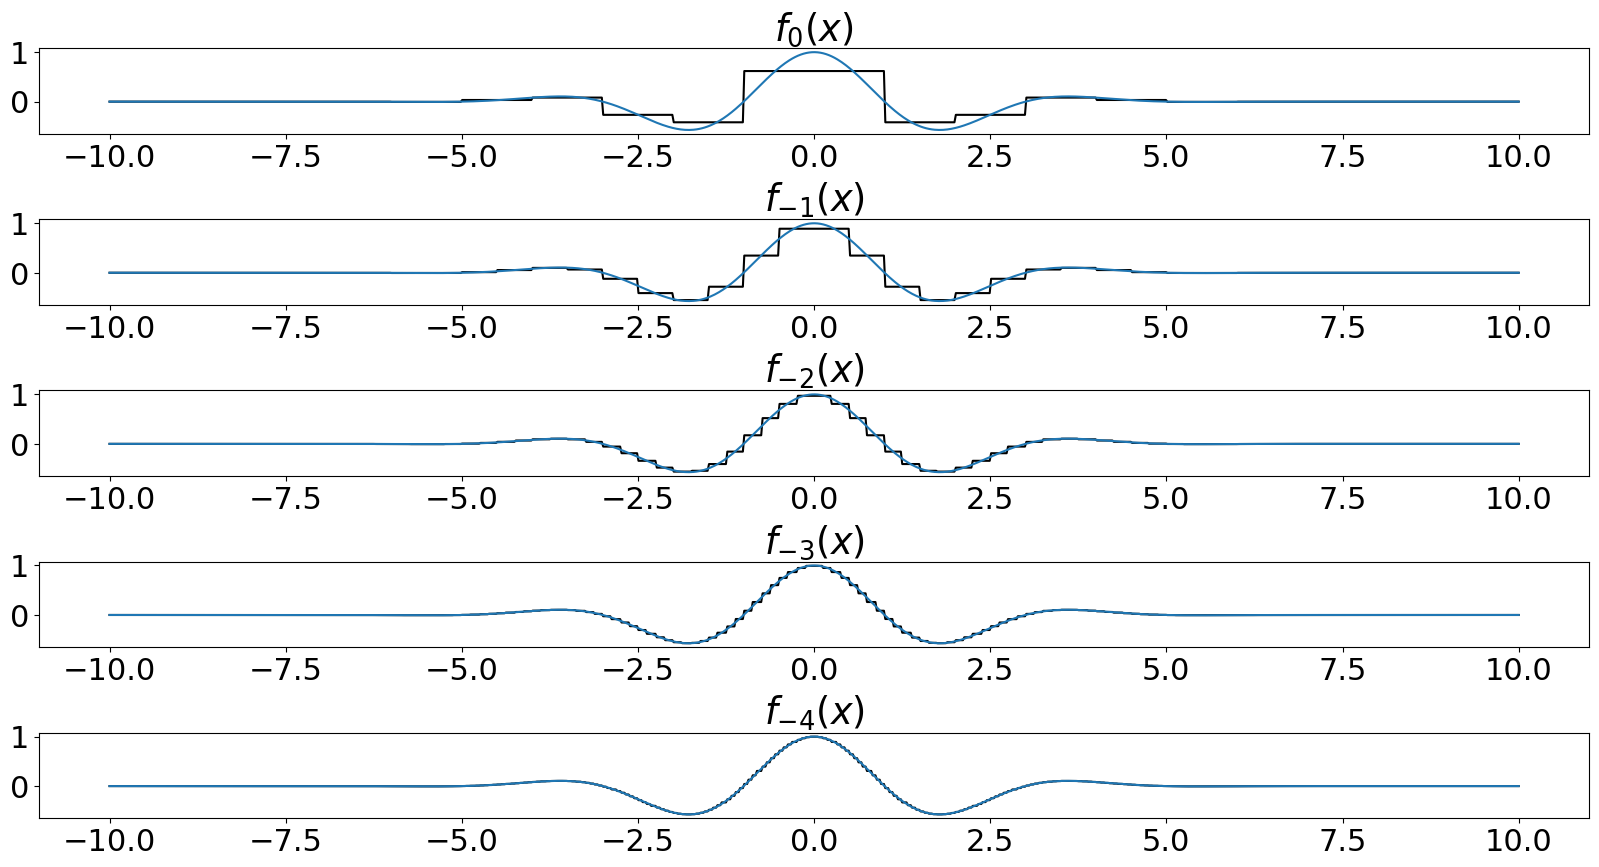

In [ ]:
fxHaar(5)
plt.savefig('haarSampling.png')
#files.download('haarSampling.png')

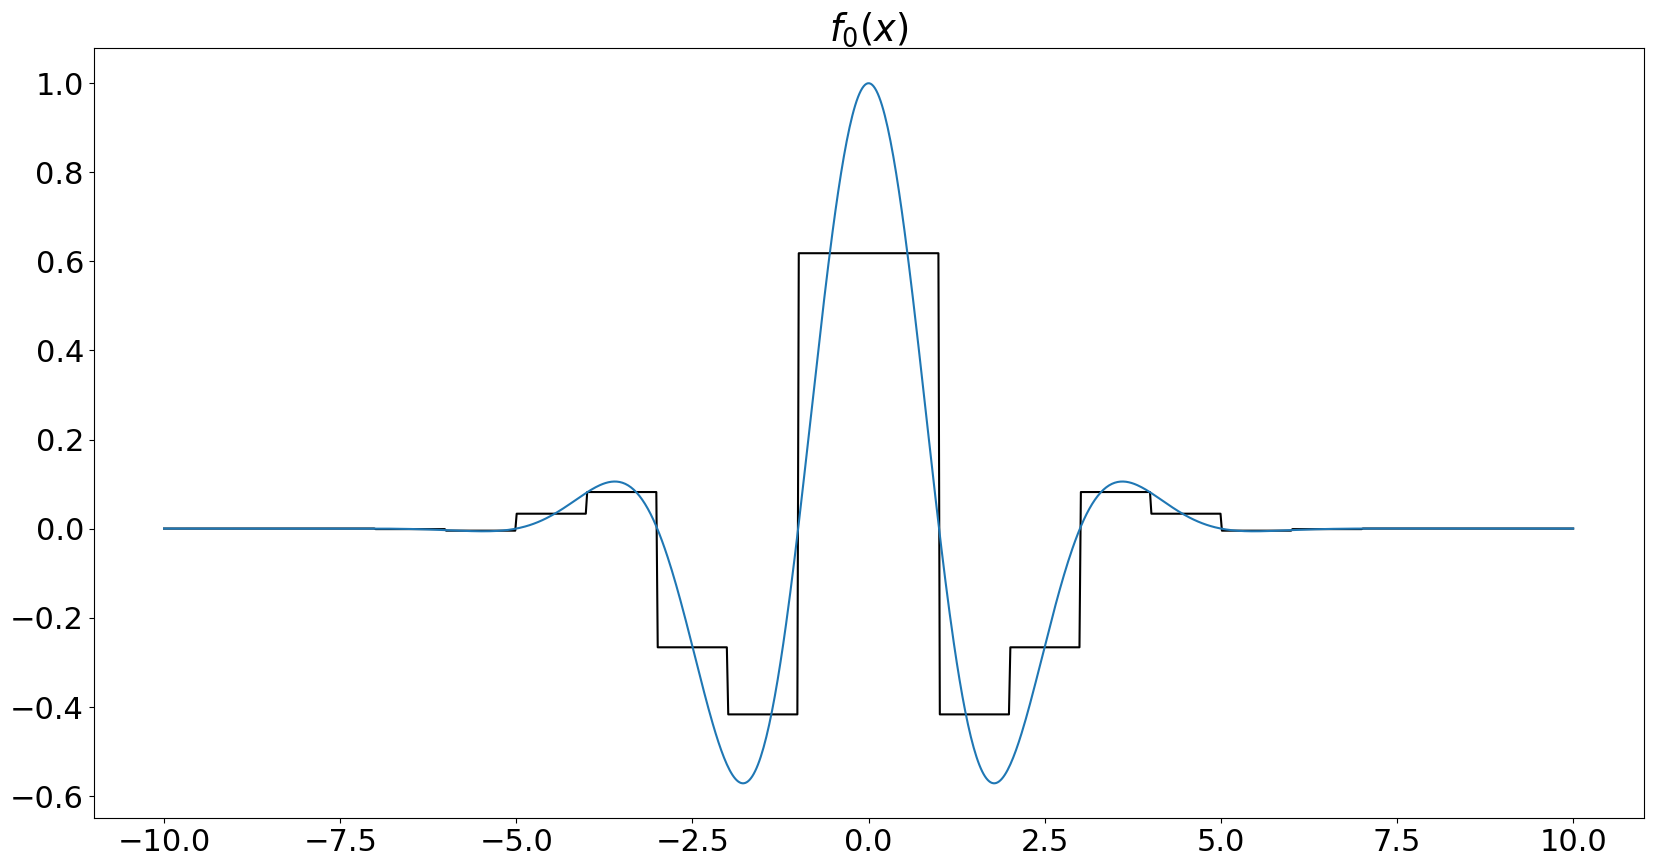

In [ ]:
fxHaar(1)

In [ ]:
!wget https://raw.githubusercontent.com/djbrady/computationalImaging/master/images/dubaiBridge.jpg

--2024-08-23 00:03:02--  https://raw.githubusercontent.com/djbrady/computationalImaging/master/images/dubaiBridge.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2542532 (2.4M) [image/jpeg]
Saving to: ‘dubaiBridge.jpg’

dubaiBridge.jpg     100%[===================>]   2.42M  11.1MB/s    in 0.2s    

2024-08-23 00:03:03 (11.1 MB/s) - ‘dubaiBridge.jpg’ saved [2542532/2542532]



In [ ]:
pop=io.imread('dubaiBridge.jpg',as_gray=True)

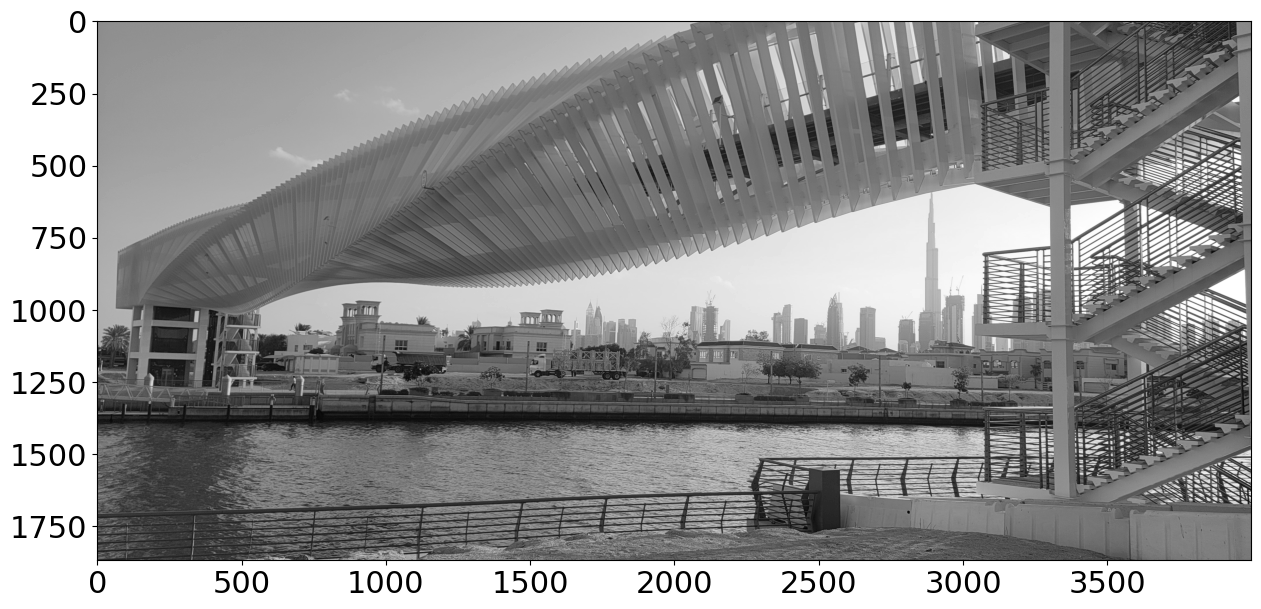

In [ ]:
plt.imshow(pop,cmap=plt.cm.gray)

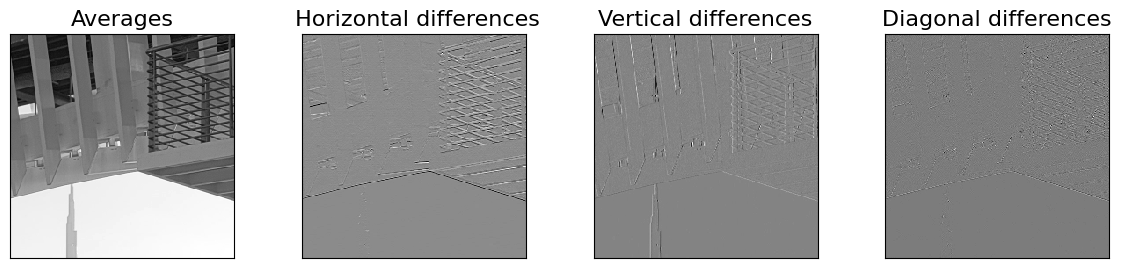

In [ ]:
# Wavelet transform of image, and plot approximation and details
titles = ['Averages', ' Horizontal differences',
          'Vertical differences', 'Diagonal differences']
coeffs2 = pywt.dwt2(pop[250:762,2750:3262], 'haar')
LL, (LH, HL, HH) = coeffs2
fig = plt.figure(figsize=(12, 3))
for i, a in enumerate([LL, LH, HL, HH]):
    ax = fig.add_subplot(1, 4, i + 1)
    ax.imshow(a, interpolation="nearest", cmap=plt.cm.gray)
    ax.set_title(titles[i], fontsize=16)
    ax.set_xticks([])
    ax.set_yticks([])
fig.tight_layout()
fig.savefig('bridge1.png', bbox_inches = 'tight', pad_inches = 0)
fig.show()
#files.download('bridge1.png')

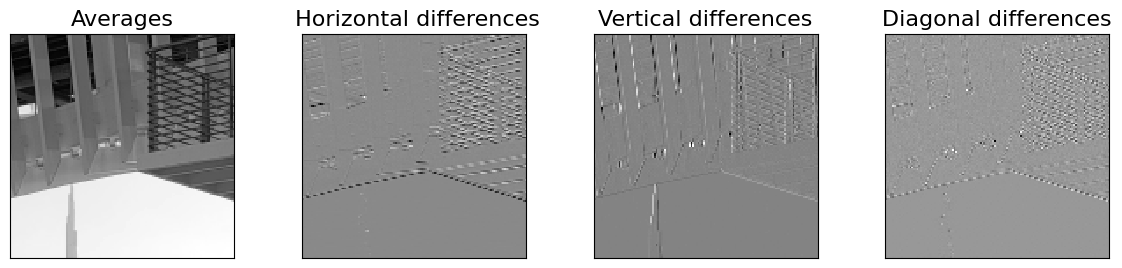

In [ ]:
# Wavelet transform of image, and plot approximation and details
titles = ['Averages', ' Horizontal differences',
          'Vertical differences', 'Diagonal differences']
coeffs2 = pywt.dwt2(LL, 'haar')
LL, (LH, HL, HH) = coeffs2
fig = plt.figure(figsize=(12, 3))
for i, a in enumerate([LL, LH, HL, HH]):
    ax = fig.add_subplot(1, 4, i + 1)
    ax.imshow(a, interpolation="nearest", cmap=plt.cm.gray)
    ax.set_title(titles[i], fontsize=16)
    ax.set_xticks([])
    ax.set_yticks([])
fig.tight_layout()
fig.savefig('bridge2.png', bbox_inches = 'tight', pad_inches = 0)
#files.download('bridge2.png')
fig.show()

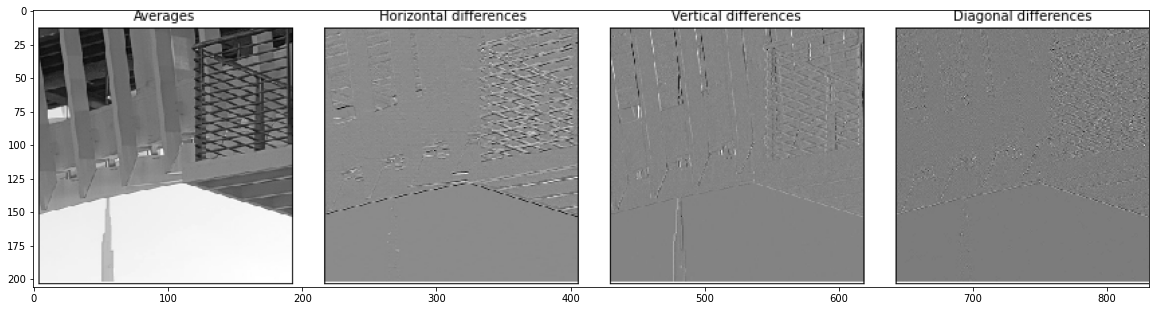

In [ ]:
plt.imshow(pip)

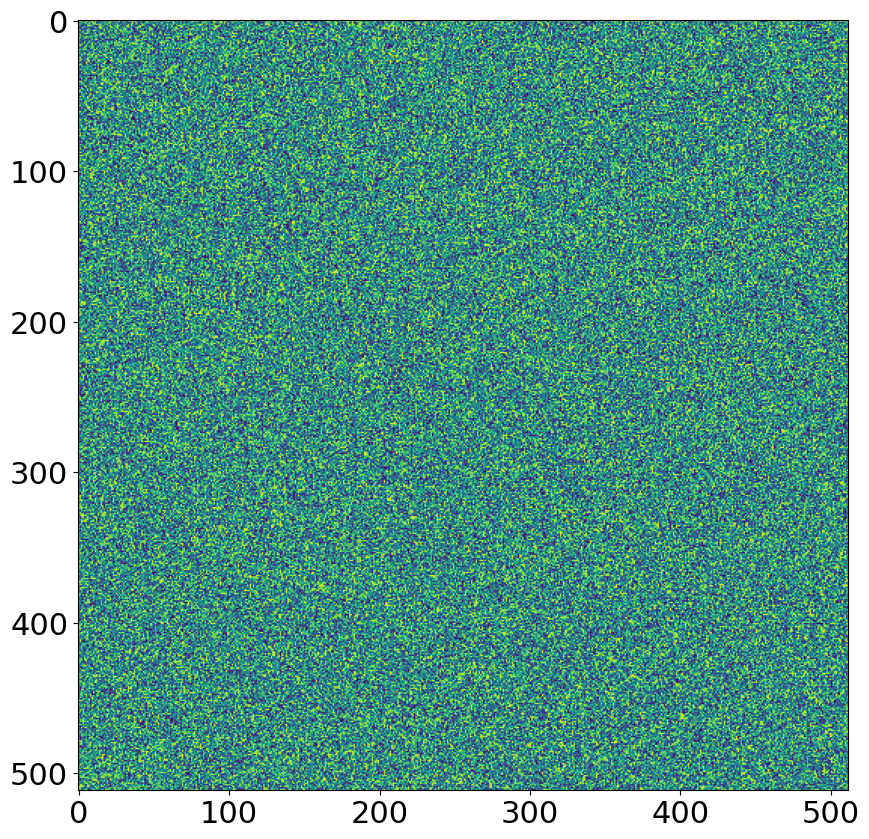

In [ ]:
pip=np.random.random((512,512))-.5
plt.imshow(pip)

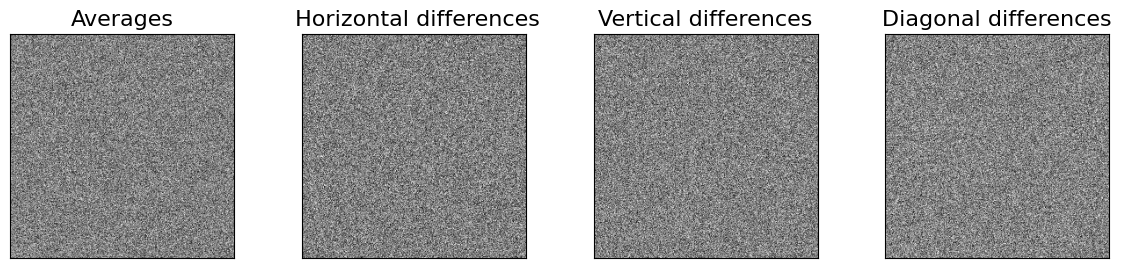

In [ ]:
# Wavelet transform of image, and plot approximation and details
titles = ['Averages', ' Horizontal differences',
          'Vertical differences', 'Diagonal differences']

coeffs2 = pywt.dwt2(pip, 'haar')
LL, (LH, HL, HH) = coeffs2
fig = plt.figure(figsize=(12, 3))
for i, a in enumerate([LL, LH, HL, HH]):
    ax = fig.add_subplot(1, 4, i + 1)
    ax.imshow(a, cmap=plt.cm.gray)
    ax.set_title(titles[i], fontsize=16)
    ax.set_xticks([])
    ax.set_yticks([])
fig.tight_layout()
fig.savefig('randomImage.png', bbox_inches = 'tight', pad_inches = 0)
fig.show()


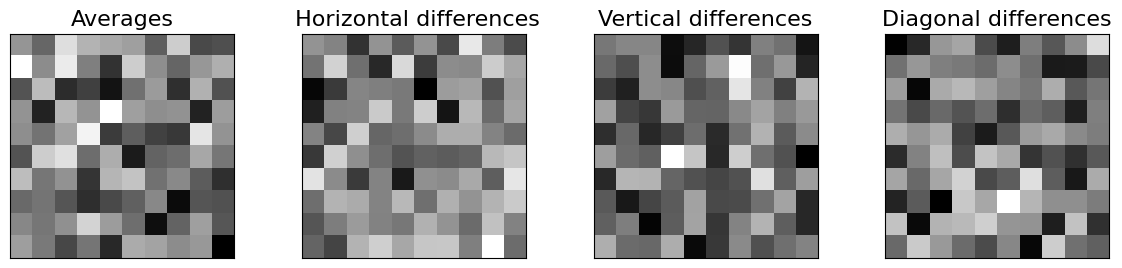

In [ ]:
# Wavelet transform of image, and plot approximation and details
titles = ['Averages', ' Horizontal differences',
          'Vertical differences', 'Diagonal differences']

coeffs2 = pywt.dwt2(pip, 'haar')
LL, (LH, HL, HH) = coeffs2
fig = plt.figure(figsize=(12, 3))
for i, a in enumerate([LL, LH, HL, HH]):
    ax = fig.add_subplot(1, 4, i + 1)
    ax.imshow(a[50:60,50:60], cmap=plt.cm.gray)
    ax.set_title(titles[i], fontsize=16)
    ax.set_xticks([])
    ax.set_yticks([])
fig.tight_layout()
fig.savefig('randomImage.png', bbox_inches = 'tight', pad_inches = 0)
fig.show()